In [1]:
# Linear-Regression - Prediction of Sell price of cars
# Ref : ChatGpt 3

import pandas as pd
from io import StringIO
import io
import requests
import json
from io import FileIO
from json import loads, dumps
# import csv
import matplotlib.pyplot as plt

# DataSet : https://github.com/Rimbik/ai-nextGen/blob/main/linear_regression/sample_dataset/realestate_ds.csv
url = "https://raw.githubusercontent.com/Rimbik/ai-nextGen/refs/heads/main/linear_regression/sample_dataset/realestate_ds.csv"
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))

df.head()

,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price
0,1,143.635030,1,3,3,1967,1,1,48,8.297631,5.935734,602134.816700
1,2,287.678577,1,2,1,1949,0,1,37,6.061466,10.827392,591425.135386
2,3,232.998485,1,3,2,1923,1,0,14,2.911442,6.904599,464478.696880
3,4,199.664621,5,2,2,1918,0,0,17,2.070949,8.284019,583105.656000
4,5,89.004660,4,3,3,1999,1,0,34,1.523278,14.648277,619879.142523


In [2]:
# VIF Technique (Variance Inflation Factor - VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

def calculate_vif(X):
    vif_data = pd.DataFrame()

    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif_data

vif_df = calculate_vif(df.drop(columns=['ID','Price']))

# drop features with high VIF values
# RULES : to identify high VIF
  # A) VIF > 10: Serious multicollinearity
  # B) VIF > 4 or 5: Moderate to high multicollinearity
  # C) VIF = 1: The predictor is not correlated with other variables

# Find >>
# A : features above 10 are considered to indicate serious multicollinearity
    # Price = This we will predict
    # serious multicollinearity [Year_Built, Square_Feet, Number_Bedroom]
# B : features that are greater than 4 or 5
    # [Garage_Size, Num_Bedrooms, Num_Floors, Num_Bathrooms]
# VIF = 1: The predictor is not correlated with other variables
    # Nil

# ---------------------------------------------------------------------------#
vif_df = vif_df.sort_values(by='VIF', ascending=False)
vif_df


,feature,VIF
4,Year_Built,40.928817
7,Garage_Size,7.931044
3,Num_Floors,7.122960
2,Num_Bathrooms,6.889979
0,Square_Feet,6.560544
1,Num_Bedrooms,5.286561
9,Distance_to_Center,4.691334
8,Location_Score,4.341567
5,Has_Garden,2.190399
6,Has_Pool,2.025920


In [3]:
# Progrmatically identify colums to be dropped
def tag_columns_tobeDropped(df):
    mydf = df.copy()

    vif_df = calculate_vif(mydf)
    vif_df["candrop"] = ""
    vif_df["drop_reason"] = "-"

    vif_df = vif_df.sort_values(by='VIF', ascending=False)

    for index, row in vif_df.iterrows():
          if row["VIF"] > 10:
              vif_df.at[index, "candrop"] = "Y"
              vif_df.at[index, "drop_reason"] = "Serious multicollinearity"

          elif row["VIF"] > 5:
              vif_df.at[index, "candrop"] = "Y"
              vif_df.at[index, "drop_reason"] = "Moderate to high multicollinearity"

          elif row["VIF"] == 1:
              vif_df.at[index, "candrop"] = "Y"
              vif_df.at[index, "drop_reason"] = "Not correlated with other variables"

          else:
              vif_df.at[index, "candrop"] = "N"
              vif_df.at[index, "drop_reason"] = "No need to drop"

    return vif_df

vif_df_indicator = tag_columns_tobeDropped(df)
vif_df_indicator



,feature,VIF,candrop,drop_reason
11,Price,116.260116,Y,Serious multicollinearity
5,Year_Built,48.649395,Y,Serious multicollinearity
1,Square_Feet,17.293680,Y,Serious multicollinearity
2,Num_Bedrooms,14.259787,Y,Serious multicollinearity
8,Garage_Size,8.187263,Y,Moderate to high multicollinearity
3,Num_Bathrooms,7.914554,Y,Moderate to high multicollinearity
4,Num_Floors,7.779240,Y,Moderate to high multicollinearity
10,Distance_to_Center,4.931112,N,No need to drop
9,Location_Score,4.550873,N,No need to drop
0,ID,4.066465,N,No need to drop


In [4]:
high_vif_features   = vif_df_indicator[vif_df_indicator["candrop"] == "Y"]
features_canbetaken = vif_df_indicator[vif_df_indicator["candrop"] == "N"]

high_vif_features = high_vif_features["feature"].tolist()
features_canbetaken = features_canbetaken["feature"].tolist()

features_canbetaken = features_canbetaken + ["Price"]
print(features_canbetaken)

model = df.filter(features_canbetaken, axis=1)
model = model.drop('ID', axis=1)
model.head() # final model to Train


['Distance_to_Center', 'Location_Score', 'ID', 'Has_Garden', 'Has_Pool', 'Price']


,Distance_to_Center,Location_Score,Has_Garden,Has_Pool,Price
0,5.935734,8.297631,1,1,602134.816700
1,10.827392,6.061466,0,1,591425.135386
2,6.904599,2.911442,1,0,464478.696880
3,8.284019,2.070949,0,0,583105.656000
4,14.648277,1.523278,1,0,619879.142523


In [5]:
model

,Distance_to_Center,Location_Score,Has_Garden,Has_Pool,Price
0,5.935734,8.297631,1,1,602134.816700
1,10.827392,6.061466,0,1,591425.135386
2,6.904599,2.911442,1,0,464478.696880
3,8.284019,2.070949,0,0,583105.656000
4,14.648277,1.523278,1,0,619879.142523
...,...,...,...,...,...
495,5.562583,4.296086,1,0,488496.350722
496,2.845105,7.406261,0,1,657736.921717
497,6.263264,8.629724,0,0,405324.950201
498,16.990684,5.318891,1,0,773035.968000


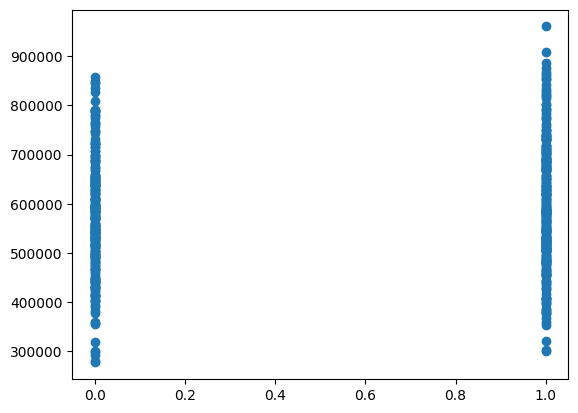

In [6]:
import matplotlib.pyplot as plt
plt.scatter(model['Has_Garden'],model['Price'])
# DOES NOT create a linear pattern if considering VIF Rules

In [7]:
## Despite bad plot on Linear Regression - Attempting Linear Regression

features_canbetaken = vif_df_indicator[vif_df_indicator["candrop"] == "N"]
features_canbetaken = features_canbetaken["feature"].tolist()

X = df[features_canbetaken]
y = df['Price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=11) #20% test Data
# use random_state to have the same selection in the record set everytime you run.

len(X_train), len(y_train),len(X_test),len(y_test)

from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X_train,y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1)

X_test


,Distance_to_Center,Location_Score,ID,Has_Garden,Has_Pool
247,9.058221,4.353242,248,0,1
239,1.396013,0.518953,240,1,1
70,0.839709,9.530200,71,0,0
136,2.673012,7.517722,137,0,1
387,12.077020,9.962623,388,1,0
...,...,...,...,...,...
230,16.656638,1.590250,231,1,1
487,18.258620,4.145161,488,1,0
153,15.535810,7.631084,154,1,1
290,6.950142,0.197957,291,0,1


In [7]:
clf.predict(X_test)

array([579285.81022354, 599945.10748942, 556615.29999036, 587860.81468074,
       607105.93057932, 586171.19122256, 566377.60720661, 557557.39785981,
       600758.62378986, 633365.80601548, 620017.61575211, 628645.78832509,
       596749.66217871, 619778.24690463, 627656.61051379, 579986.92196955,
       537040.17211501, 575547.16394575, 597226.17643796, 572377.49274106,
       543684.6741074 , 627722.82069182, 601155.76712428, 590240.34904171,
       610058.28856414, 630444.42833528, 571912.59308255, 568114.50029623,
       605619.46187301, 539916.75780128, 587699.6994554 , 597465.56253828,
       570283.87985816, 597687.68351549, 554779.19470246, 571390.90608281,
       599474.26632189, 645227.28524394, 605421.98907604, 593661.12855254,
       548101.72144456, 567024.84124164, 596217.65028046, 599980.33241668,
       550230.17612055, 592415.1282817 , 590951.75504332, 626327.76920676,
       571825.77479529, 568937.1048666 , 596483.10295523, 603264.03958226,
       565680.68313443, 6

In [8]:
# Get Score/Correctness
clf.score(X_test,y_test) # getting bogus score so may be "Overfitting"

0.01338353135705972

In [8]:
#Attempt: 3
vif_df_indicator

X = df.filter(['Garage_Size','Num_Bathrooms','Num_Floors','Distance_to_Center','Location_Score','Has_Garden','Has_Pool'], axis=1)
y = df['Price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=11) #20% test Data
# use random_state to have the same selection in the record set everytime you run.

len(X_train), len(y_train),len(X_test),len(y_test)

from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1)

clf.score(X_test,y_test)


0.02426376161650956

In [9]:

import altair as alt

alt.Chart(df).mark_circle().encode(
    x='Square_Feet',
    y='Price'
)

alt.Chart(...)

In [10]:

import altair as alt

alt.Chart(df).mark_circle().encode(
    x='Has_Pool',
    y='Price'
)

alt.Chart(...)

<!-- Year_Built	40.928817
7	Garage_Size	7.931044
3	Num_Floors	7.122960
2	Num_Bathrooms	6.889979
0	Square_Feet	6.560544
1	Num_Bedrooms	5.286561
9	Distance_to_Center	4.691334
8	Location_Score	4.341567
5	Has_Garden	2.190399
6	Has_Pool	2.025920 -->



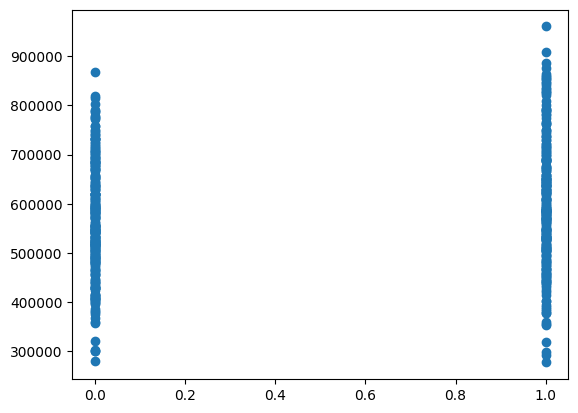

In [11]:
# Garage_Size	8.187263	Y	Moderate to high multicollinearity
# 3	Num_Bathrooms	7.914554	Y	Moderate to high multicollinearity
# 4	Num_Floors	7.779240	Y	Moderate to high multicollinearity
# 10	Distance_to_Center	4.931112	Y	Moderate to high multicollinearity
# 9	Location_Score	4.550873	Y	Moderate to high multicollinearity
# 0	ID	4.066465	Y	Moderate to high multicollinearity
# 6	Has_Garden	2.319956	N	No need to drop
# 7	Has_Pool
plt.scatter(df['Has_Pool'],df['Price'])


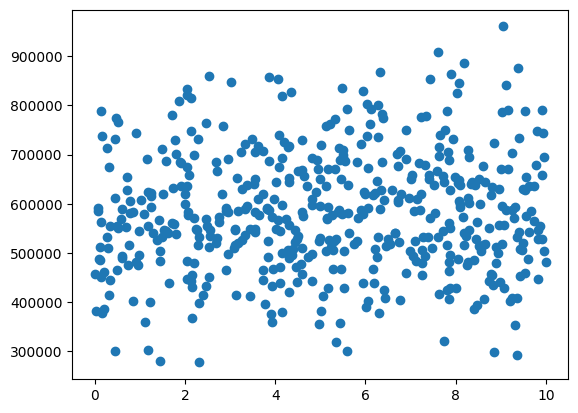

In [12]:
plt.scatter(df['Location_Score'],df['Price'])

In [13]:
# x='Square_Feet',    y='Price' : IS THE BEST CANDIDATE

#Attempt: 4
vif_df_indicator

X = df.filter(['Square_Feet'], axis=1)
y = df['Price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=11) #20% test Data
# use random_state to have the same selection in the record set everytime you run.

len(X_train), len(y_train),len(X_test),len(y_test)

from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1)

clf.score(X_test,y_test)

0.28047436436453677

In [14]:
# apply polynomial regression
# Train polynomial regression model on the whole dataset

X = df.filter(['Garage_Size','Num_Bathrooms','Num_Floors','Distance_to_Center','Location_Score','Has_Garden','Has_Pool'], axis=1)
y = df['Price']

from sklearn.preprocessing import PolynomialFeatures
# Train linear regression model on whole dataset
lr = LinearRegression()
lr.fit(X, y)

# Train polynomial regression model on the whole dataset
pr = PolynomialFeatures(degree = 4)
X_poly = pr.fit_transform(X)
lr_2 = LinearRegression()
lr_2.fit(X_poly, y)

# Predict results
y_pred_lr = lr.predict(X)           # Linear Regression
y_pred_poly = lr_2.predict(X_poly)  # Polynomial Regression
